# Imports

In [ ]:
!pip install qiskit qiskit_aer qiskit_ibm_runtime pylatexenc

In [7]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp, Operator
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit import ParameterVector
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter
from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorV2 as Estimator, SamplerV2 as Sampler
# from qiskit.primitives import BackendEstimator as Estimator, Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


import numpy as np
from scipy.optimize import minimize
from scipy.linalg import expm
from scipy.stats.qmc import Sobol
from scipy.stats import norm, entropy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import tqdm


In [8]:
def copy_circ(params, num_qubits):
    qc = QuantumCircuit(num_qubits)
    for i, j in params:
        qc.cx(i, j)
    return qc

def swap_gates():
    qc = QuantumCircuit(8)

    qc.swap(0, 4)
    qc.swap(1, 5)
    qc.swap(2, 6)
    qc.swap(3, 7)

    qc = qc.to_gate(label='SWAP')

    return qc

def getIntFromBinary(nums):
    n = len(nums)
    out = 0
    count = 0
    for bit in nums:
        if(bit == 1):
            out += pow(2,n - count - 1)
        count+=1
    return out


# Inputs

In [9]:
plaintext = '10010111'
key="1010101010"

# S-DES Blackbox


In [10]:
def sdes_encrypt(plaintext, key):
    # Helper functions
    def permute(bits, table):
        return [bits[i-1] for i in table]

    def left_shift(bits, n):
        return bits[n:] + bits[:n]

    def xor(bits1, bits2):
        return [b1 ^ b2 for b1, b2 in zip(bits1, bits2)]

    def sbox_lookup(bits, sbox):
        row = bits[0]*2 + bits[3]
        col = bits[1]*2 + bits[2]
        val = sbox[row][col]
        return [val // 2, val % 2]

    # Permutation and S-box tables
    P10 = [3,5,2,7,4,10,1,9,8,6]
    P8 = [6,3,7,4,8,5,10,9]
    IP = [2,6,3,1,4,8,5,7]
    IP_inv = [4,1,3,5,7,2,8,6]
    EP = [4,1,2,3,2,3,4,1]
    P4 = [2,4,3,1]
    S0 = [[1,0,3,2],
          [3,2,1,0],
          [0,2,1,3],
          [3,1,3,2]]
    S1 = [[0,1,2,3],
          [2,0,1,3],
          [3,0,1,0],
          [2,1,0,3]]

    # Convert input strings to bit lists
    plaintext_bits = [int(b) for b in plaintext]
    key_bits = [int(b) for b in key]

    # Key generation
    key_p10 = permute(key_bits,P10)
    left_key,right_key = key_p10[:5],key_p10[5:]

    left_key_ls1 = left_shift(left_key , 1)
    right_key_ls1= left_shift(right_key , 1)
    k1 = permute(left_key_ls1 + right_key_ls1,P8)

    left_key_ls2= left_shift(left_key_ls1 , 2)
    right_key_ls2= left_shift(right_key_ls1 , 2)
    k2 = permute(left_key_ls2 + right_key_ls2,P8)

    # Initial permutation
    ip_bits = permute(plaintext_bits , IP)

    # Round function
    def fk(bits,key):
        left,right=bits[:4],bits[4:]
        expanded_right=permute(right , EP)
        xor_result=xor(expanded_right,key)

        sbox_out=sbox_lookup(xor_result[:4],S0)+sbox_lookup(xor_result[4:],S1)
        p4_out=permute(sbox_out,P4)

        return xor(left,p4_out)+right

    # First round with K1
    round_1=fk(ip_bits,k1)

    # Switch halves
    round_1_swapped=round_1[4:]+round_1[:4]

    # Second round with K2
    round_2=fk(round_1_swapped,k2)

    # Final permutation (IP inverse)
    cipher_bits=permute(round_2 , IP_inv)

    return ''.join(str(b) for b in cipher_bits)

# Example usage:
ciphertext = sdes_encrypt(plaintext,key)
print("Ciphertext:", ciphertext)

Ciphertext: 11111110


In [11]:
def random_8bit_string():
    """Generate a random 8-bit bitstring as a string of '0's and '1's."""
    return ''.join(np.random.choice(['0', '1'], size=8))

plaintexts = [random_8bit_string() for _ in range(20)]
ciphertexts = [sdes_encrypt(plaintext, key) for plaintext in plaintexts]

In [12]:
ciphertexts

['10010010',
 '11000101',
 '00000010',
 '00111111',
 '00100101',
 '10110111',
 '10110110',
 '10011011',
 '11110100',
 '00001011',
 '11101101',
 '10110011',
 '11000001',
 '01110010',
 '11011001',
 '01001110',
 '00111010',
 '11000110',
 '10000100',
 '10001111']

In [13]:
sample_plaintext = plaintexts[np.random.randint(0, len(plaintexts))]
sample_key = '1000000001'
sample_cipher = sdes_encrypt(sample_plaintext, sample_key)
print("Ciphertext:", sample_cipher)

Ciphertext: 11100111


# Prior Probability

In [14]:
def gaussian_prior(n_bits, center_key, std_dev):
    all_keys = np.array([list(map(int, format(i, f'0{n_bits}b'))) for i in range(2**n_bits)])
    hamming_dist = np.array([np.sum(k != center_key) for k in all_keys])
    probs = norm.pdf(hamming_dist, 0, std_dev)
    return probs / np.sum(probs)



In [15]:
n_bits = 10
center_key = np.array(list(map(int, '1000000000')))
prior = gaussian_prior(n_bits, center_key, std_dev=1.5)
prior

array([1.57646125e-02, 8.09382193e-03, 8.09382193e-03, ...,
       1.31087280e-08, 1.31087280e-08, 2.99842031e-10])

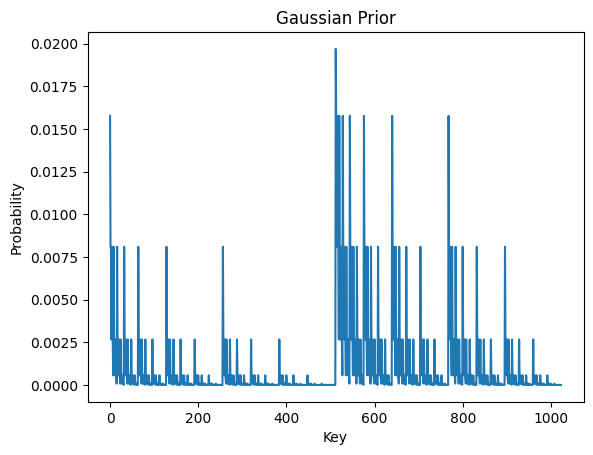

In [16]:
plt.plot(prior)
plt.xlabel('Key')
plt.ylabel('Probability')
plt.title('Gaussian Prior')
plt.show()

# Ansatz

## Old Ansatz

### Ansatz gates

In [17]:
# Y - Cy Ansatz
def ansatz_cy_1(theta, qc):
    n = qc.num_qubits
    qc.h(np.arange(n))

    params = ParameterVector('P', length=len(theta))
    # Apply Ry rotations based on the parameters
    for qubit in range(n):
        qc.ry(params[qubit], qubit)

    # Add controlled gates (CNOTs)
    for i in range(n):
        qc.cy(i, (i+1)%n)

    return qc

def ansatz_cy_2(theta, qc):
    n = qc.num_qubits
    qc.h(np.arange(n))

    # Apply Ry rotations based on the parameters
    for qubit in range(n):
        qc.ry(theta[qubit], qubit)

    # Add controlled gates (CNOTs)
    for i in range(n):
        if(i < n - 1):
            qc.cy(i, (i+1)%n)
    return qc

def layered_ansatz(theta, layers=2):
    qc = QuantumCircuit(len(theta), len(theta))
    n = qc.num_qubits
    params = ParameterVector('P', length=layers * n)

    qc.h(np.arange(n))  # Initial superposition

    for l in range(layers):
        # Parameterized rotations
        for i in range(n):
            qc.ry(params[l * n + i], i)
        # Entangling CY layer
        for i in range(n):
            qc.cy(i, (i + 1) % n)

    return qc


In [18]:
test_params = np.linspace(0, 10, 10)
test_qc = QuantumCircuit(10, 10)
qc_ansatz = ansatz_cy_1(test_params, test_qc)
qc_new = qc_ansatz.assign_parameters(test_params)


### Ansatz Gate

In [19]:
def generate_ansatz_gate(params, num_qubits):
    qc_temp = QuantumCircuit(num_qubits)
    ansatz_circuit = ansatz_cy_1(params, qc_temp)
    ansatz_circuit.remove_final_measurements()  # Remove any final measurements (optional)
    ansatz_circuit.data = [instr for instr in ansatz_circuit.data if instr.operation.name != "barrier"]

    ansatz_gate = ansatz_circuit.to_gate(label='Ansatz')

    return ansatz_gate


## New Ansatz

In [20]:
def create_improved_ansatz(num_qubits=10):
    # Create parameter vectors
    theta = ParameterVector('θ', num_qubits)
    phi = ParameterVector('φ', num_qubits)
    lambda_ = ParameterVector('λ', num_qubits)

    # Create quantum circuit with 10 qubits
    qc = QuantumCircuit(num_qubits)

    # Apply Hadamard gates to all qubits
    qc.h(range(num_qubits))

    # Apply additional U gates after entanglement
    for i in range(num_qubits):
        qc.u(theta[i], phi[i], lambda_[i], i)
        qc.cx(i, (i + 1) % num_qubits)
        qc.cx(i, (i - 1) % num_qubits)

    return qc, list(theta), list(phi), list(lambda_)


def create_ansatz_with_params(theta_vals, phi_vals, lambda_vals):
    num_qubits = len(theta_vals)
    qc = QuantumCircuit(num_qubits)

    qc.h(range(num_qubits))

    for i in range(num_qubits):
        qc.u(theta_vals[i], phi_vals[i], lambda_vals[i], i)
        qc.cx(i, (i + 1) % num_qubits)
        qc.cx(i, (i - 1) % num_qubits)

    return qc

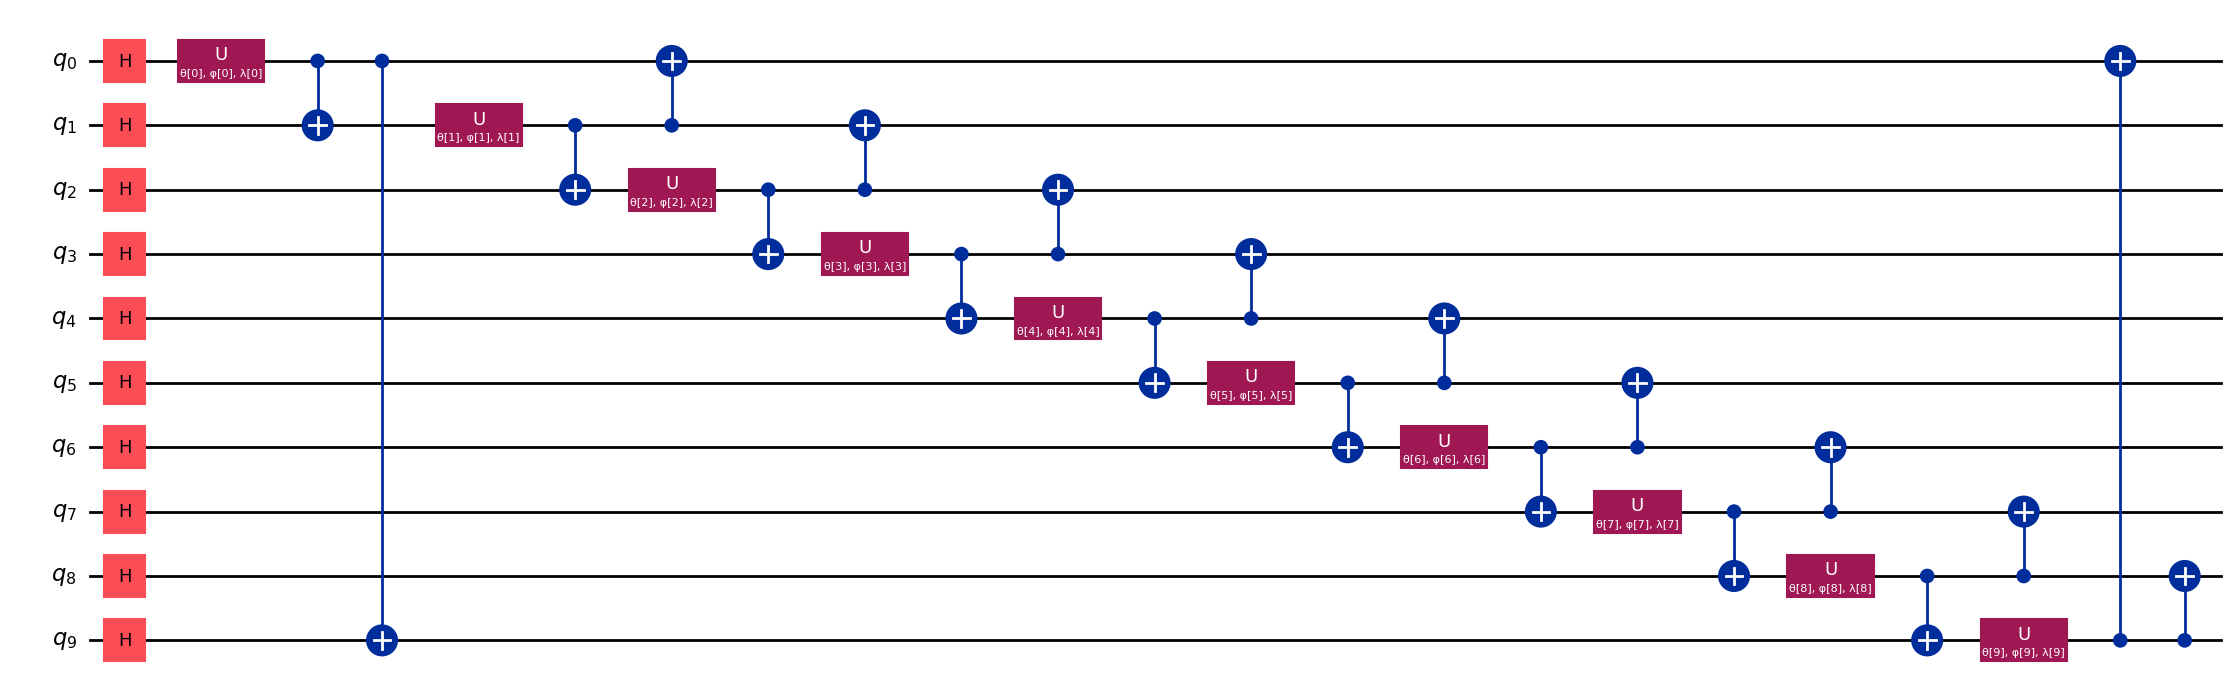

In [21]:
nans, th, ph, lm = create_improved_ansatz(10)
display(nans.draw('mpl', fold=-1))

# Pre Training and Parameter Initialization

## Sample Distribution

In [22]:
def get_probabilities_from_sampler(qc, theta_params, phi_params, lambda_params, full_param_vector, shots=4096):
    backend = AerSimulator(method='matrix_product_state')
    qc.measure_all()
    transpiled_qc = transpile(qc, backend)

    sampler = Sampler(backend)

    # Unpack full_param_vector (length 30) into θ, φ, λ each of length 10
    n = len(theta_params)
    theta_vals = full_param_vector[:n]
    phi_vals = full_param_vector[n:2*n]
    lambda_vals = full_param_vector[2*n:]

    bound_params = dict(zip(
        theta_params + phi_params + lambda_params,
        list(theta_vals) + list(phi_vals) + list(lambda_vals)
    ))

    job = sampler.run([(transpiled_qc, bound_params)])
    result = job.result()
    bit_array = result[0].data
    samples = bit_array['meas']
    counts = samples.get_counts()

    probs = np.zeros(2**qc.num_qubits)
    for bitstring, prob in counts.items():
        probs[int(bitstring, 2)] = prob

    return probs


## KL Divergence Loss Function

In [23]:
def kl_divergence_loss(full_param_vector, prior_probs, qc, theta_params, phi_params, lambda_params):
    q_probs = get_probabilities_from_sampler(
        qc,
        theta_params,
        phi_params,
        lambda_params,
        full_param_vector
    )

    eps = 1e-10
    prior_probs = np.clip(prior_probs, eps, 1.0)
    q_probs = np.clip(q_probs, eps, 1.0)
    ent = entropy(prior_probs, q_probs)  # D_KL(P || Q)
    # print(ent)
    return ent


## Optimize initial params

In [24]:
def random_10bit_string():
    """Generate a random 10-bit bitstring as a string of '0's and '1's."""
    return ''.join(np.random.choice(['0', '1'], size=10))

random_key = random_10bit_string()
print(random_key)

0011011010


In [25]:
# 🧪 Step 6: Setup and Run Optimization
n_bits = 10
center_key = np.array(list(map(int, '1010000001')))
prior_probs = gaussian_prior(n_bits, center_key, std_dev=1.5)

qc, theta_params, phi_params, lambda_params = create_improved_ansatz(n_bits)
init_params = np.random.uniform(0, 2*np.pi, 3 * n_bits)

pbar = tqdm(total=1000, desc="Optimizing", unit="step")


def tracked_loss(params):
    loss = kl_divergence_loss(params)
    pbar.update(1)
    return loss

res = minimize(
    kl_divergence_loss,
    init_params,
    args=(prior_probs, qc, theta_params, phi_params, lambda_params),
    method='L-BFGS-B',
    options={'maxiter': 100}
)

pbar.close()

Optimizing:   0%|          | 0/1000 [20:01<?, ?step/s]


In [26]:
theta_opt = res.x[:n_bits]
phi_opt = res.x[n_bits:2*n_bits]
lambda_opt = res.x[2*n_bits:]

In [27]:
theta_opt

array([1.82041302, 2.28290531, 1.19763271, 5.8786094 , 6.21420951,
       1.2237247 , 5.03672192, 5.58317377, 1.33595253, 2.73012741])

## Final probs

In [28]:
prior_probs

array([2.66442942e-03, 8.09382193e-03, 5.62386681e-04, ...,
       6.60446023e-06, 1.31087280e-08, 3.67458947e-07])

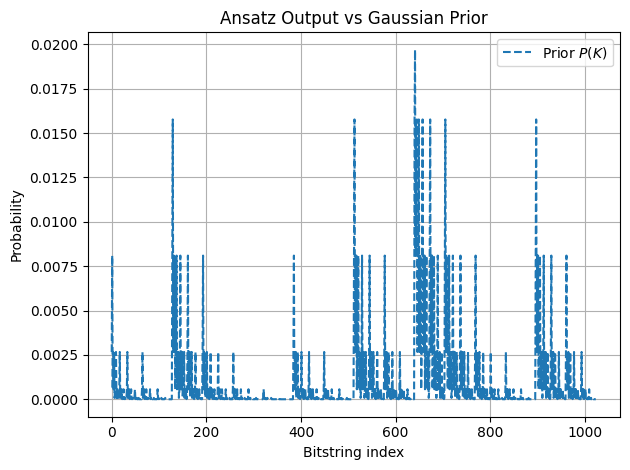

In [29]:
plt.plot(prior_probs, label='Prior $P(K)$', linestyle='--')
plt.xlabel("Bitstring index")
plt.ylabel("Probability")
plt.title("Ansatz Output vs Gaussian Prior")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

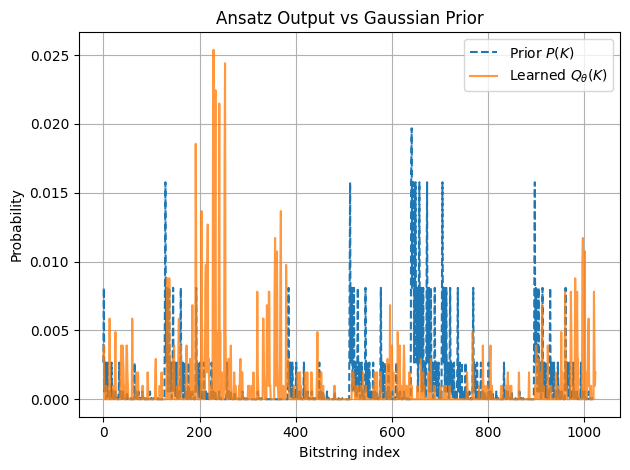

In [30]:
# 📊 Step 7: Visualize Final Result
final_probs = get_probabilities_from_sampler(qc, theta_params, phi_params, lambda_params,
                                             list(theta_opt) + list(phi_opt) + list(lambda_opt)
)

l = len(final_probs)
final_probs = final_probs / np.sum(final_probs)

plt.plot(prior_probs, label='Prior $P(K)$', linestyle='--')
plt.plot(final_probs, label='Learned $Q_\\theta(K)$', alpha=0.8)
plt.xlabel("Bitstring index")
plt.ylabel("Probability")
plt.title("Ansatz Output vs Gaussian Prior")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Circuit simulation with initial params

In [31]:
len(list(theta_opt) + list(phi_opt) + list(lambda_opt))

30

In [32]:
qc_sample = QuantumCircuit(10, 10)

# ansatz_gate = generate_ansatz_gate(params, num_qubits=10)
ansatz_gate, theta_params, phi_params, lambda_params = create_improved_ansatz(num_qubits=10)

qc_sample.compose(ansatz_gate, inplace=True)
qc_sample.measure(range(10), range(10))

backend = AerSimulator(method='matrix_product_state')
transpiled_qc = transpile(qc_sample, backend)

sampler = Sampler(backend)


job = sampler.run([(transpiled_qc, dict(zip(
            theta_params + phi_params + lambda_params,
            list(theta_opt) + list(phi_opt) + list(lambda_opt)
        )))])

result = job.result()



In [33]:
bit_array = result[0].data.c

In [34]:
counts = bit_array.get_counts()
max_element = max(counts, key=counts.get)
max_count = counts[max_element]

print(max_element)
print(max_count)

0011100100
30


# Input plain-cipher pair

In [35]:
plaintext = plaintexts[0]
ciphertext_input = ciphertexts[0]

In [59]:
plaintext

'01010100'

In [61]:
ciphertext_input

'10010010'

# Cost Function

## Hamiltonian Cost Function

In [36]:
ciphertext = []
for c in ciphertext_input:
    ciphertext.append(c)
cipherNum = getIntFromBinary(ciphertext)

sample_ciphertexts = [ [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 1, 0, 0], [0, 1, 1, 0, 1, 0, 1, 1], [1, 0, 0, 1, 0, 1, 0, 0], ciphertext]

# Graph edges
edges = [
    (0, 1), (0, 2), (0, 3),
    (1, 4), (1, 5), (1, 0),
    (2, 6), (2, 7), (2, 0),
    (3, 5), (3, 6), (3, 0),
    (4, 5), (4, 1), (4, 7),
    (5, 3), (5, 4), (5, 1),
    (6, 2), (6, 3), (6, 7),
    (7, 2), (7, 4), (7, 6)
]

# Hamiltonian
hamiltonian_terms = []

# pairwise z gates from graph
n = len(ciphertext)
for i, j in edges:
    zstring = ""


    for k in np.arange(7,-1, -1):
        if(k == i or k == j):
            zstring += 'Z'
        else:
            zstring += 'I'

    if ciphertext[n - i - 1] != ciphertext[n - j - 1]:
        hamiltonian_terms.append((1, Pauli(zstring))) # w_ij = +1
    else:
        hamiltonian_terms.append((-1, Pauli(zstring))) # w_ij = -1

# single-qubit gates
for i in range(n):
    zstring = ""
    for k in np.arange(7, -1, -1):
        if(k == i):
            zstring += 'Z'
        else:
            zstring += 'I'

    if ciphertext[n - i - 1] == '1':
        hamiltonian_terms.append((0.5, Pauli(zstring))) # t_i = +0.5
    else:
        hamiltonian_terms.append((-0.5, Pauli(zstring))) # t_i = -0.5

coeffs = []
pauliList = []

for coeff, pauli in hamiltonian_terms:
    coeffs.append(coeff)
    pauliList.append(pauli)

# hamiltonian_ops
hamiltonian_operator = SparsePauliOp(pauliList, coeffs) # Hermitian Hamiltonian operator
hamiltonian_matrix = hamiltonian_operator.to_matrix()
hamiltonian = UnitaryGate(expm(-1j * hamiltonian_matrix), label='hamiltonian') # Unitary Hamiltonian Operator

In [37]:
hamiltonian_operator

SparsePauliOp(['IIIIIIZZ', 'IIIIIZIZ', 'IIIIZIIZ', 'IIIZIIZI', 'IIZIIIZI', 'IIIIIIZZ', 'IZIIIZII', 'ZIIIIZII', 'IIIIIZIZ', 'IIZIZIII', 'IZIIZIII', 'IIIIZIIZ', 'IIZZIIII', 'IIIZIIZI', 'ZIIZIIII', 'IIZIZIII', 'IIZZIIII', 'IIZIIIZI', 'IZIIIZII', 'IZIIZIII', 'ZZIIIIII', 'ZIIIIZII', 'ZIIZIIII', 'ZZIIIIII', 'IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'],
              coeffs=[ 1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j,  1. +0.j,  1. +0.j, -1. +0.j,
  1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j,  1. +0.j, -1. +0.j,
 -1. +0.j, -1. +0.j,  1. +0.j,  1. +0.j, -1. +0.j, -1. +0.j,  1. +0.j,
  1. +0.j, -1. +0.j,  1. +0.j, -0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j,
  0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5+0.j])

In [38]:
hamiltonian

Instruction(name='unitary', num_qubits=8, num_clbits=0, params=[array([[ 0.28366219-0.95892427j,  0.        +0.j        ,
         0.        +0.j        , ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  1.        -0.j        ,
         0.        +0.j        , ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.83907153-0.54402111j, ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       ...,
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , ...,  0.96017029-0.2794155j ,
         0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , ...,  0.        +0.j        ,
         1.        -0.j        ,  0.        +0.j        ],
       [ 0.        +0.j 

In [39]:
ciphertext

['1', '0', '0', '1', '0', '0', '1', '0']

In [40]:
for sample_cipher in sample_ciphertexts:
    # Convert the sample ciphertext to a string
    sample_cipher = ''.join(map(str, sample_cipher))
    print("Sample Ciphertext:", sample_cipher)
    sv_ham = Statevector.from_label(sample_cipher)
    display(sv_ham.draw('latex'))
    sv_ham = sv_ham.evolve(hamiltonian)
    display(sv_ham.draw('latex'))
    display(sv_ham.to_dict())
    print(sv_ham.expectation_value(hamiltonian_operator).real)


Sample Ciphertext: 00000000


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

{np.str_('00000000'): np.complex128(0.28366218546322625-0.9589242746631385j)}

-4.999999999999999
Sample Ciphertext: 00010100


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

{np.str_('00010100'): np.complex128(-0.9899924966004454-0.1411200080598672j)}

2.999999999999999
Sample Ciphertext: 01101011


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

{np.str_('01101011'): np.complex128(-0.4161468365471424-0.9092974268256817j)}

2.0
Sample Ciphertext: 10010100


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

{np.str_('10010100'): np.complex128(-0.4161468365471424+0.9092974268256817j)}

-2.0
Sample Ciphertext: 10010010


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

{np.str_('10010010'): np.complex128(-0.9626058663135666+0.27090578830786904j)}

-28.0


In [41]:
print(len(pauliList))

32


## Hamming Distance Cost Function

In [42]:
def hamming_distance(str1, str2):
    # Ensure the two strings are of the same length
    if len(str1) != len(str2):
        raise ValueError("Bit strings must have the same length")

    # Calculate the number of positions where the bits are different
    distance = sum(c1 != c2 for c1, c2 in zip(str1, str2))
    return distance

# Example usage
bit_string1 = "10101"
bit_string2 = "11000"
print("Hamming Distance:", hamming_distance(bit_string1, bit_string2))


Hamming Distance: 3


# Circuit

## Cryptanalysis & Classical Optimisation

### Circuit initialization

In [43]:

qc = QuantumCircuit(10, 10)

ansatz_gate, theta_params, phi_params, lambda_params = create_improved_ansatz(10)
all_params = theta_params + phi_params + lambda_params

qc.compose(ansatz_gate, inplace=True)
qc.measure(range(10), range(10))

backend = AerSimulator(method='matrix_product_state')
transpiled_qc = transpile(qc, backend, optimization_level=1)

sampler = Sampler(backend)
print(sampler)

### Helper functions for optimization

In [44]:
def counts_to_prob_dist(counts_dict):
    """
    Convert a counts dictionary (from bit_array.get_counts())
    into a probability distribution dictionary mapping bitstrings to probabilities.

    Args:
        counts_dict (dict): Dictionary with bitstrings as keys and counts as values.

    Returns:
        dict: Dictionary with bitstrings as keys and probabilities as values.
    """
    total_shots = sum(counts_dict.values())
    if total_shots == 0:
        raise ValueError("Total number of shots is zero, cannot normalize to probabilities.")

    prob_dist = {bitstring: count / total_shots for bitstring, count in counts_dict.items()}
    return prob_dist

def encrypt_dict_keys(input_dict):
    """
    Encrypts the keys of a dictionary using the SDES encryption function.

    Parameters:
        input_dict (dict): The input dictionary with keys to be encrypted.
        encryption_key (str): The encryption key to be used for SDES encryption.

    Returns:
        dict: A new dictionary with encrypted keys.
    """
    encrypted_dict = {}
    for key, value in input_dict.items():
        # Encrypt the key using the SDES encryption function
        encrypted_key = sdes_encrypt(plaintext, key)
        # Add the encrypted key and value to the new dictionary
        encrypted_dict[encrypted_key] = value
    return encrypted_dict

def pauli_eigenvalue(pauli, bitstring):
    """
    Compute the eigenvalue of a diagonal Pauli operator (only I and Z)
    for a given bitstring.

    Parameters:
      pauli: a Qiskit Pauli object.
      bitstring: a string of bits (e.g. '0101').

    Returns:
      The eigenvalue (+1 or -1).

    Note:
      Qiskit's Pauli label is returned by pauli.to_label(), where the rightmost
      character corresponds to qubit 0. If the measured bitstring is longer than the
      number of qubits acted on by the Hamiltonian, we take the rightmost bits.
    """
    label = pauli.to_label()      # e.g. "IZZI"
    n = len(label)
    if len(bitstring) != n:
        if len(bitstring) > n:
            # Take the rightmost n bits
            bitstring = bitstring[-n:]
        else:
            raise ValueError("Mismatch in qubit count between pauli operator and bitstring.")

    # Reverse both label and bitstring to align qubit indices (qubit 0 = index 0).
    label = label[::-1]
    bitstring = bitstring[::-1]

    eigenvalue = 1
    for op, bit in zip(label, bitstring):
        if op == 'I':
            continue
        elif op == 'Z':
            if bit == '1':
                eigenvalue *= -1
        else:
            raise ValueError("Non-diagonal Pauli operator encountered: {}.".format(label[::-1]))
    return eigenvalue

def compute_expectation_from_dist(prob_dist, hamiltonian_operator):
    """
    Compute the expectation value given a probability distribution and a Hamiltonian operator.

    Parameters:
      - prob_dist: Dictionary mapping bitstrings to probabilities.
      - hamiltonian_operator: SparsePauliOp representing the Hamiltonian.

    Returns:
      - The expectation value as a float.
    """
    expectation_value = 0
    for pauli_term, coeff in zip(hamiltonian_operator.paulis, hamiltonian_operator.coeffs):
        term_exp_val = 0
        for bitstring, prob in prob_dist.items():
            eigenvalue = pauli_eigenvalue(pauli_term, bitstring)
            term_exp_val += eigenvalue * prob
        expectation_value += coeff * term_exp_val
    return np.real(expectation_value)

def build_param_groups(flat_params, num_qubits=10):
    theta = flat_params[:num_qubits]
    phi = flat_params[num_qubits:2*num_qubits]
    lambda_ = flat_params[2*num_qubits:3*num_qubits]
    return [theta, phi, lambda_]

def compute_gradient(params, sampler, transpiled_qc, hamiltonian_operator,
                     theta_params, phi_params, lambda_params, shift=np.pi/2):
    """
    Compute the gradient of the expectation value w.r.t. each parameter
    using the parameter-shift rule.

    Returns:
        grad: A NumPy array of shape (3, num_qubits).
    """
    flat_params = params.flatten()
    num_params = len(flat_params)
    gradient = np.zeros(num_params)

    for i in range(num_params):
        shifted_plus = flat_params.copy()
        shifted_minus = flat_params.copy()

        shifted_plus[i] += shift
        shifted_minus[i] -= shift

        # Group into parameter sets
        p_theta, p_phi, p_lambda = build_param_groups(shifted_plus)
        m_theta, m_phi, m_lambda = build_param_groups(shifted_minus)

        # Bind + shift
        binding_plus = dict(zip(theta_params + phi_params + lambda_params,
                                p_theta.tolist() + p_phi.tolist() + p_lambda.tolist()))
        result_plus = sampler.run([(transpiled_qc, binding_plus)]).result()
        counts_plus = result_plus[0].data.c.get_counts()
        counts_plus = encrypt_dict_keys(counts_plus)
        prob_plus = counts_to_prob_dist(counts_plus)
        exp_plus = compute_expectation_from_dist(prob_plus, hamiltonian_operator)

        # Bind - shift
        binding_minus = dict(zip(theta_params + phi_params + lambda_params,
                                 m_theta.tolist() + m_phi.tolist() + m_lambda.tolist()))
        result_minus = sampler.run([(transpiled_qc, binding_minus)]).result()
        counts_minus = result_minus[0].data.c.get_counts()
        counts_minus = encrypt_dict_keys(counts_minus)
        prob_minus = counts_to_prob_dist(counts_minus)
        exp_minus = compute_expectation_from_dist(prob_minus, hamiltonian_operator)

        # Gradient for this parameter
        gradient[i] = (exp_plus - exp_minus) / (2 * np.sin(shift))

    return gradient.reshape(3, -1)  # Shape: (3, num_qubits)



### Optimization loop

In [45]:
# Hyperparameters
max_iterations = 300
learning_rate = 0.3
tolerance = 1e-6
num_epochs = 5
num_initializations = 1
momentum_beta = 0.9  # Momentum coefficient

# Storage for history: structure [initialization][epoch][iteration]
all_param_history = []       # Full param history: init -> epoch -> iter
all_cost_history = []        # Full cost history: init -> epoch -> iter
best_costs = []              # Best cost per initialization
best_params = []             # Best params per initialization

for k in range(num_initializations):
    print(f"\n=== Initialization {k + 1} ===")

    # Initial parameters for kth run
    params = res.x.reshape(3, 10)

    init_param_history = []
    init_cost_history = []

    best_init_cost = float('inf')
    best_init_params = None

    for epoch in range(num_epochs):
        print(f"\nStarting epoch {epoch + 1}")

        epoch_costs = []
        epoch_params = []

        # Initialize velocity for momentum
        velocity = np.zeros_like(params)

        for iteration in tqdm(range(max_iterations), desc=f"Iterations (epoch {epoch + 1})", leave=False):
            # Compute expectation value using Sampler
            job = sampler.run([(
                transpiled_qc,
                dict(zip(
                    theta_params + phi_params + lambda_params,
                    params[0].tolist() + params[1].tolist() + params[2].tolist()
                ))
            )])
            result = job.result()
            pub_result = result[0]
            bit_array = pub_result.data.c
            bit_array_dict = bit_array.get_counts()
            bit_array_dict = encrypt_dict_keys(bit_array_dict)
            prob_dist = counts_to_prob_dist(bit_array_dict)

            # Cost (expectation value)
            exp_val = compute_expectation_from_dist(prob_dist, hamiltonian_operator)
            epoch_costs.append(exp_val)

            # Compute gradient
            gradients = compute_gradient(
                params,
                sampler,
                transpiled_qc,
                hamiltonian_operator,
                theta_params,
                phi_params,
                lambda_params
            )

            # Momentum-based gradient descent update
            velocity = momentum_beta * velocity - learning_rate * gradients
            params = params + velocity
            epoch_params.append(params.tolist())

            # Convergence check
            if np.linalg.norm(gradients) < tolerance:
                print(f"Converged at iteration {iteration + 1}")
                break

        init_cost_history.append(epoch_costs)
        init_param_history.append(epoch_params)

        # Update best epoch result for current initialization
        best_iter_index = np.argmin(epoch_costs)
        best_epoch_cost = epoch_costs[best_iter_index]
        best_epoch_params = epoch_params[best_iter_index]
        print(f"Epoch {epoch + 1} best cost: {best_epoch_cost}")

        # Keep best of all epochs for this initialization
        if best_epoch_cost < best_init_cost:
            best_init_cost = best_epoch_cost
            best_init_params = best_epoch_params

        # Carry best params into next epoch
        params = np.array(best_epoch_params)

    # Save full initialization history
    all_param_history.append(init_param_history)
    all_cost_history.append(init_cost_history)
    best_costs.append(best_init_cost)
    best_params.append(best_init_params)

# === Final Summary ===
print("\n=== Final Optimization Summary ===")
for i, cost in enumerate(best_costs):
    print(f"Initialization {i + 1}: Best cost = {cost}")



=== Initialization 1 ===

Starting epoch 1


Epoch 1 best cost: -11.955990220048895

Starting epoch 2


Epoch 2 best cost: -9.43731490621915

Starting epoch 3


Epoch 3 best cost: -8.69662921348315

Starting epoch 4


Epoch 4 best cost: -8.375469336670838

Starting epoch 5


Epoch 5 best cost: -10.697148475909538

=== Final Optimization Summary ===
Initialization 1: Best cost = -11.955990220048895


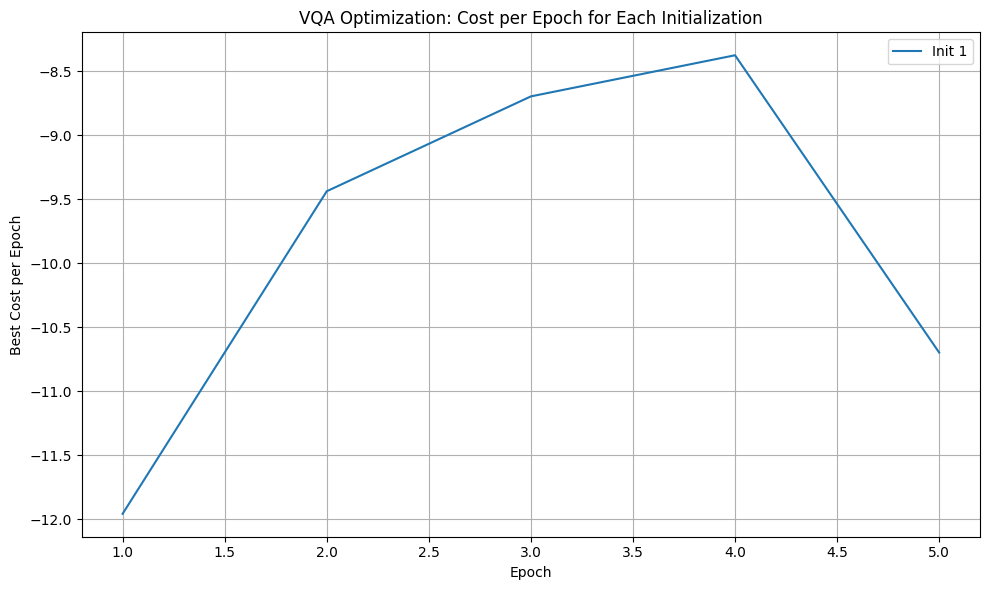

In [46]:
plt.figure(figsize=(10, 6))

for init_index, epoch_costs in enumerate(all_cost_history):
    # For each epoch, get the minimum cost achieved across all iterations
    min_costs_per_epoch = [min(iter_costs) for iter_costs in epoch_costs]

    plt.plot(range(1, len(min_costs_per_epoch) + 1), min_costs_per_epoch, label=f'Init {init_index + 1}')

plt.xlabel("Epoch")
plt.ylabel("Best Cost per Epoch")
plt.title("VQA Optimization: Cost per Epoch for Each Initialization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
import os

def get_next_plot_path(folder_path="./cost plots", ext="png"):
    os.makedirs(folder_path, exist_ok=True)

    existing = [f for f in os.listdir(folder_path) if f.endswith(f".{ext}")]
    existing_nums = []
    for fname in existing:
        try:
            num = int(os.path.splitext(fname)[0])
            existing_nums.append(num)
        except ValueError:
            continue

    next_num = max(existing_nums, default=0) + 1
    filename = f"{next_num}.{ext}"
    return os.path.join(folder_path, filename)


Plot saved to: cost_plots/1.png


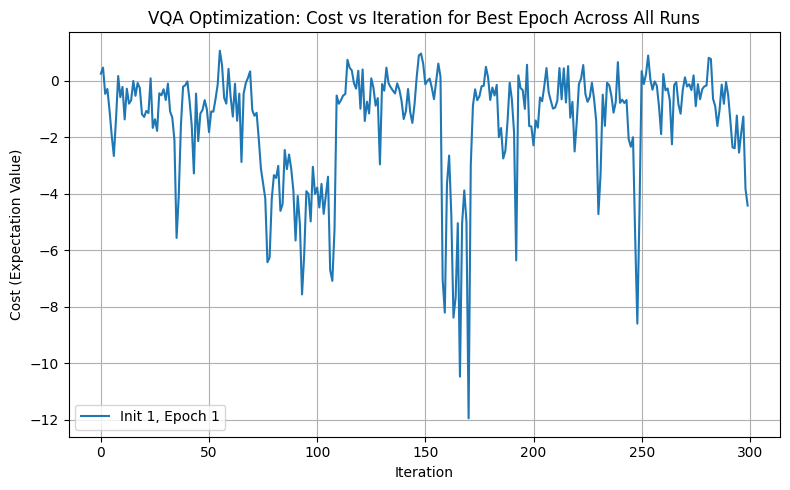

In [48]:
# Find the (init, epoch) pair with the global minimum cost
min_cost = float('inf')
min_cost_epoch_data = None

for init_idx, epoch_list in enumerate(all_cost_history):
    for epoch_idx, iter_costs in enumerate(epoch_list):
        current_min = min(iter_costs)
        if current_min < min_cost:
            min_cost = current_min
            min_cost_epoch_data = {
                "init_idx": init_idx,
                "epoch_idx": epoch_idx,
                "costs": iter_costs
            }

# Plot that best epoch
plt.figure(figsize=(8, 5))
plt.plot(min_cost_epoch_data["costs"], label=f'Init {min_cost_epoch_data["init_idx"]+1}, Epoch {min_cost_epoch_data["epoch_idx"]+1}')
plt.xlabel('Iteration')
plt.ylabel('Cost (Expectation Value)')
plt.title('VQA Optimization: Cost vs Iteration for Best Epoch Across All Runs')
plt.grid(True)
plt.legend()
plt.tight_layout()
save_path = get_next_plot_path("cost_plots")
plt.savefig(save_path)
print(f"Plot saved to: {save_path}")
plt.show()


## Finding the result key

In [49]:
best_init_idx = min_cost_epoch_data["init_idx"]
best_param = best_params[best_init_idx]
best_param = np.array(best_param)
best_param

array([[  8.17542439, -10.56029837,  -5.23606216, -15.02847096,
         -4.526506  ,  19.64950515,  10.55814506,  24.69085073,
          4.802382  ,  11.93675253],
       [  6.02014362,  -1.69934189,   0.24628068,   5.26711421,
         17.26083991,  24.21301264,   1.05226835,   3.94340954,
         -4.28255959,  18.37025493],
       [ 21.60790643,   6.50015416,   2.36992061,   6.52650448,
         -6.1520709 ,  -6.02364905, -11.11288985,  12.4322935 ,
        -15.18024367,  15.89735097]])

In [50]:
import os

def extract_plot_number(path):
    # Get the filename like "7.png"
    filename = os.path.basename(path)
    # Remove extension and convert to int
    number = int(os.path.splitext(filename)[0])
    return number



plot_num = extract_plot_number(save_path)
print(f"Plot number: {plot_num}")  # Output: Plot number: 7


Plot number: 1


In [51]:
with open("./cost_plots/params.txt", "a") as f:
    f.write(f"\n Params for plot number : #{plot_num} \n")
    f.write(f"init_params : {params} \n")
    f.write(f"best_params : {best_param} \n \n")

In [52]:
params = best_param.tolist()

In [53]:
params

[[8.175424388268699,
  -10.560298366735356,
  -5.236062162363889,
  -15.028470963642222,
  -4.526505998064201,
  19.649505150867128,
  10.558145057589265,
  24.690850733553823,
  4.802381996727298,
  11.936752532902029],
 [6.020143620750483,
  -1.6993418885353482,
  0.246280682511474,
  5.267114210411691,
  17.26083991352687,
  24.213012635488212,
  1.0522683501974592,
  3.9434095394077353,
  -4.2825595912299885,
  18.370254932099826],
 [21.607906429103906,
  6.500154158305241,
  2.3699206104764765,
  6.526504481902924,
  -6.1520709002345395,
  -6.023649047050184,
  -11.112889851221288,
  12.432293499579158,
  -15.180243668844565,
  15.897350965425312]]

In [54]:
type(params)

list

In [55]:
qc = QuantumCircuit(10, 10)

# ansatz_gate = generate_ansatz_gate(params, num_qubits=10)
ansatz_gate, theta_params, phi_params, lambda_params = create_improved_ansatz(num_qubits=10)

qc.compose(ansatz_gate, inplace=True)
qc.measure(range(10), range(10))

backend = AerSimulator(method='matrix_product_state')
transpiled_qc = transpile(qc, backend)

sampler = Sampler(backend)


job = sampler.run([(transpiled_qc, dict(zip(
            theta_params + phi_params + lambda_params,
            params[0] + params[1] + params[2]
        )))])

result = job.result()
bit_array = result._pub_results[0].data.c
counts = bit_array.get_counts()

max_element = max(counts, key=counts.get)
max_count = counts[max_element]

print(max_element)
print(max_count)

1010101010
143


In [56]:
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
sorted_counts

[('1010101010', 143),
 ('1011001010', 128),
 ('1001101010', 51),
 ('1000001010', 50),
 ('0110101011', 41),
 ('1010101100', 38),
 ('1011001100', 34),
 ('1010100110', 32),
 ('1010011010', 30),
 ('0111001011', 28),
 ('1001100110', 17),
 ('0101101011', 16),
 ('0100001011', 16),
 ('1000001100', 15),
 ('1011000110', 15),
 ('1011111010', 13),
 ('0110100111', 13),
 ('1010101011', 13),
 ('1001101100', 13),
 ('1100101010', 12),
 ('1010101001', 11),
 ('0110011011', 10),
 ('1011000000', 9),
 ('1000111010', 9),
 ('0110101101', 8),
 ('1101001010', 8),
 ('1000000110', 8),
 ('1010100000', 8),
 ('0111000111', 7),
 ('0111111011', 7),
 ('1001100000', 7),
 ('1011001001', 6),
 ('1110001010', 5),
 ('1001011010', 5),
 ('1010011100', 5),
 ('1011001011', 5),
 ('1100101100', 5),
 ('0101100111', 4),
 ('1101001100', 4),
 ('1111101010', 4),
 ('1001101011', 4),
 ('1000001001', 4),
 ('0100000111', 4),
 ('1011000111', 4),
 ('1001011100', 3),
 ('0110011101', 3),
 ('1011111001', 3),
 ('0101101101', 3),
 ('1011010010', 

In [ ]:
ciphers = encrypt_dict_keys(counts)
ciphers

In [58]:
cipher_text_obtained = sdes_encrypt(plaintext, max_element)
cipher_text_obtained

'10010010'